In [103]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 815.8 kB/s eta 0:00:00:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.4 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.0 MB/s eta 0:00:00a 0:00:01


In [110]:
!pip install matplotlib

In [104]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.9 MB/s eta 0:00:00a 0:00:01


In [133]:
!pip install pymystem3

In [161]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 4.1 MB/s eta 0:00:00-:--:--


In [24]:
import re
import string
import nltk
import emoji
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from datasets import load_dataset
from transformers import DebertaV2Tokenizer, DebertaV2Model
from wordcloud import WordCloud
from pymystem3 import Mystem

In [2]:
from nltk.corpus import stopwords

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/benrise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('datasets/bootcamp.csv')
df_agg = pd.read_csv('datasets/bootcamp_agg.csv')

In [5]:
df.head()

,Unnamed: 0,dialog_id,bot_name,is_bot,text
0,0,29bb5e1d-e311-4932-a420-e9611497bcd9,random_user,0,Привет?
1,1,29bb5e1d-e311-4932-a420-e9611497bcd9,GPTBot,1,Привет! Как твои дела?
2,2,29bb5e1d-e311-4932-a420-e9611497bcd9,random_user,0,Ха ха - я тебя раскусил ты GPT бот)
3,3,29bb5e1d-e311-4932-a420-e9611497bcd9,GPTBot,1,"Ха-ха, ну, значит, мне нужно постараться ещё л..."
4,4,29bb5e1d-e311-4932-a420-e9611497bcd9,random_user,0,Я блефовал)\nТы спалился


In [6]:
df_agg.head()

,Unnamed: 0,dialog_id,bot_name,is_bot,text
0,0,000600a4-bb35-458b-8fd7-6e139f94650e,Alinastya,1,['Service unavailable']
1,1,000600a4-bb35-458b-8fd7-6e139f94650e,random_user,0,['привет']
2,2,0077a8b6-1a67-4b46-95e7-526d7feabc20,Sasha,1,"['Service unavailable', 'Service unavailable',..."
3,3,0077a8b6-1a67-4b46-95e7-526d7feabc20,random_user,0,"['Всем привет!', 'Уф', 'Кто же ты', 'Ну явно б..."
4,4,009952d5-6538-4a69-b5dd-f1ec76608391,BotTeamIB,1,"['""Чио Рио"" – это, вероятно, отсылка к популяр..."


In [7]:
df.describe()

,Unnamed: 0,is_bot
count,6868.000000,6868.000000
mean,3433.500000,0.429965
std,1982.765157,0.495107
min,0.000000,0.000000
25%,1716.750000,0.000000
50%,3433.500000,0.000000
75%,5150.250000,1.000000
max,6867.000000,1.000000


In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df_agg.drop(columns=['Unnamed: 0'], inplace=True)

# 1. Классификация отдельных сообщений


## 1.1 Предобработка + небольшой анализ

### Почистим данные

In [9]:
df.isna().sum()

dialog_id     0
bot_name      0
is_bot        0
text         22
dtype: int64

In [10]:
df.dropna(inplace=True)
df.isna().sum()

dialog_id    0
bot_name     0
is_bot       0
text         0
dtype: int64

In [11]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].astype(str).apply(clean_text)

In [12]:
print(df['is_bot'].value_counts()) # 60% людей и 40% ботов

is_bot
0    3915
1    2931
Name: count, dtype: int64


In [13]:
human_text = df[df['is_bot'] == 0].text
bot_text = df[df['is_bot'] == 1].text

In [14]:
def count_punctuation(message: str) -> int:
    return sum(1 for char in message if char in string.punctuation)

def avg_punctuation(messages: list) -> float:
    total_punctuation = sum(count_punctuation(msg) for msg in messages)
    return total_punctuation / len(messages)


avg_human_punctuation = avg_punctuation(human_text)
avg_bot_punctuation = avg_punctuation(bot_text)

print('Среднее кол-во знаков для сообщений людей', avg_human_punctuation)
print('Среднее кол-во знаков для сообщений ботов', avg_bot_punctuation)

Среднее кол-во знаков для сообщений людей 1.5075351213282249
Среднее кол-во знаков для сообщений ботов 3.008188331627431


In [15]:
def count_unique_words(message: str) -> int:
    words = message.translate(str.maketrans('', '', string.punctuation)).lower().split()
    return len(set(words))

def avg_unique_words(messages: list) -> float:
    total_unique_words = sum(count_unique_words(msg) for msg in messages)
    return total_unique_words / len(messages)

avg_bot_unique_words = avg_unique_words(bot_text)
avg_human_unique_words = avg_unique_words(human_text)

print('Среднее кол-во уникальных слов у людей:', avg_human_unique_words)
print('Среднее кол-во уникальных слов у ботов:', avg_bot_unique_words)

Среднее кол-во уникальных слов у людей: 2.713409961685824
Среднее кол-во уникальных слов у ботов: 8.088365745479358


In [16]:
def tokenize(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return set(text.split())

human_words = set().union(*df[df['is_bot'] == 0]['text'].apply(tokenize))
bot_words = set().union(*df[df['is_bot'] == 1]['text'].apply(tokenize))

unique_human_words = human_words - bot_words
unique_bot_words = bot_words - human_words

print("Уникальные слова людей:", len(unique_human_words), list(unique_human_words)[:20])
print("Уникальные слова ботов:", len(unique_bot_words), list(unique_bot_words)[:20])

Уникальные слова людей: 1348 ['nodownloaderavailable', 'say', 'setting', 'blb', 'ет', 'child', '202020029', 'потеряно', '9d703303238d1', 'выкладывай', 'оим', 'es', 'русские', 'билибоба', 'выфв', '202019627', 'twithshowdetailsevent', 'бинарное', 'голос', 'филосо́фия']
Уникальные слова ботов: 4108 ['самолёты', 'романтическими', 'взбей', 'влияет', 'моделей', 'мыслителей', 'занимаешася', 'javascript', 'принимай', 'улучшенной', 'прогулку', 'необыжный', 'будущем', 'твоём', 'моментами', 'сочинять', 'сложилось', 'curious', 'распределение', 'подстраивания']


In [17]:
def preprocess_message(message: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    message_cleaned = message.translate(translator)

    return message_cleaned.lower()

bot_text_processed = [preprocess_message(msg) for msg in bot_text]
human_text_processed = [preprocess_message(msg) for msg in human_text]

In [18]:
def plot_wordcloud(text_list, title):
    text = " ".join(text_list)
    wordcloud = WordCloud(
        width=800,
        height=400,
        max_font_size=50,
        max_words=50,
        background_color="white",
        stopwords=None
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

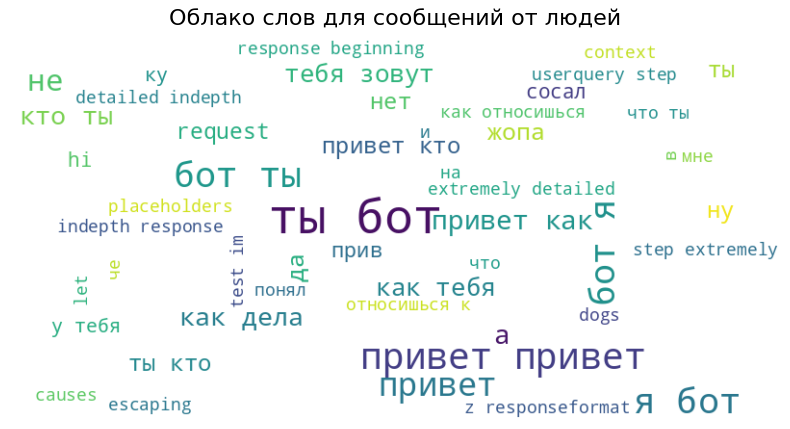

In [19]:
plot_wordcloud(human_text_processed, "Облако слов для сообщений от людей")

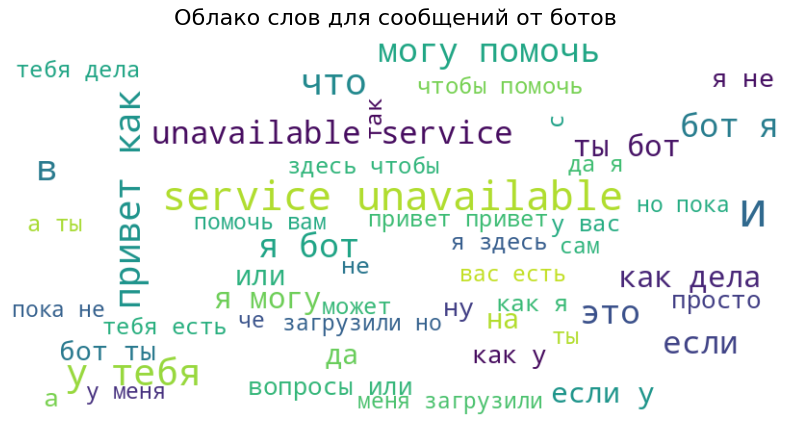

In [20]:
plot_wordcloud(bot_text_processed, "Облако слов для сообщений от ботов")

### 1.2 FE

In [21]:
def text_length(text):
    return len(text)

def exclamation_count(text):
    return text.count('!')

def question_count(text):
    return text.count('?')

def emoji_count(text):
    return len([char for char in text if char in emoji.EMOJI_DATA])

def repetition_count(text):
    words = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
    word_counts = {word: words.count(word) for word in set(words)}
    return sum(count > 1 for count in word_counts.values())

df['text_length'] = df['text'].apply(text_length)
df['exclamation_count'] = df['text'].apply(exclamation_count)
df['question_count'] = df['text'].apply(question_count)
df['emoji_count'] = df['text'].apply(emoji_count)
df['repetition_count'] = df['text'].apply(repetition_count)

df[['text', 'text_length', 'exclamation_count', 'question_count', 'emoji_count', 'repetition_count']].head()

,text,text_length,exclamation_count,question_count,emoji_count,repetition_count
0,Привет?,7,0,1,0,0
1,Привет! Как твои дела?,22,1,1,0,0
2,Ха ха - я тебя раскусил ты GPT бот),35,0,0,0,1
3,"Ха-ха, ну, значит, мне нужно постараться ещё л...",84,1,1,0,0
4,Я блефовал) Ты спалился,23,0,0,0,0


### 1.3 Обучение (TF-IDF + Лог. регрессия)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])

print(X.shape)

(6846, 5000)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, df['is_bot'], test_size=0.2, random_state=42, shuffle=True)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.89      0.80       794
           1       0.78      0.56      0.65       576

    accuracy                           0.75      1370
   macro avg       0.76      0.72      0.73      1370
weighted avg       0.76      0.75      0.74      1370



### 1.4 Экспорт

In [25]:
joblib.dump(model, 'message_bot_classifier_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']